https://colab.research.google.com/github/Lucien-Piat/DEL_Single_Tree_Detection/blob/main/notebook.ipynb

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from IPython.display import clear_output

import os

In [5]:
work_dir = "./raw_data/"
mask_dir = work_dir + "separated_masks/"
tile_dir = work_dir + "tiles/"

mask_paths = sorted([mask_dir + f for f in os.listdir(mask_dir)])
tile_paths = sorted([tile_dir + f for f in os.listdir(tile_dir)])

mask_tiles = list(zip(mask_paths, tile_paths))

Tile shape (1024, 1024, 4)
Mask shape (1024, 1024)


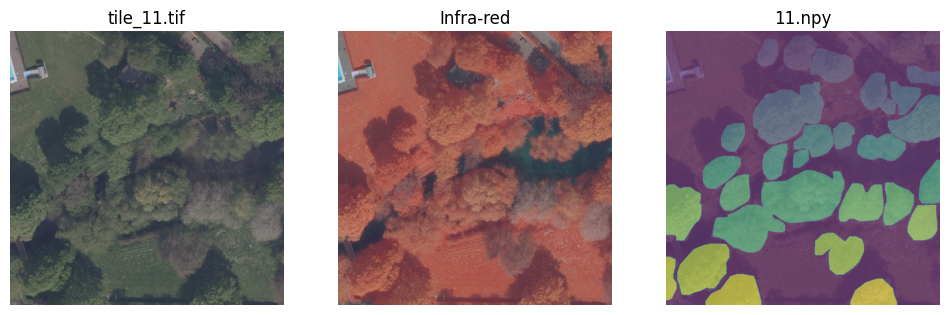

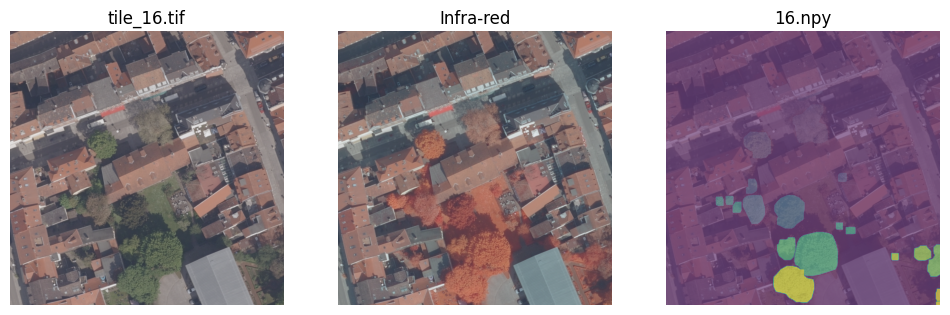

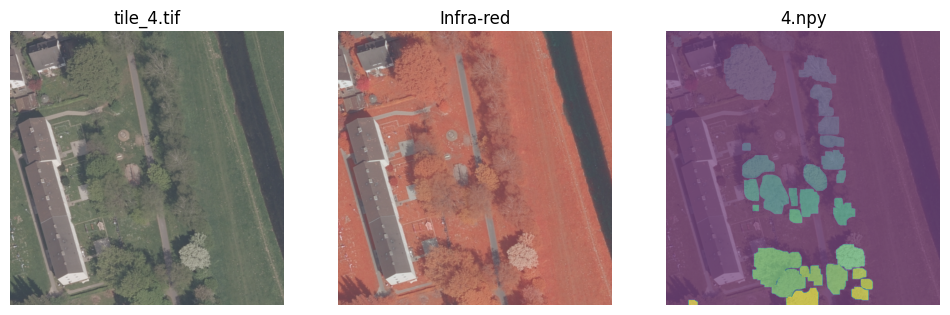

In [7]:
a = np.random.choice(len(mask_tiles), 3)
a = [mask_tiles[i] for i in a]

for mask_path, tile_path in a:
    tile = Image.open(tile_path)
    tile = np.array(tile)

    # TODO: check if the axis is correct
    tile_image = tile[:, :, :3] / 255.0
    tile_infred = tile[:, :, 3]

    mask = np.load(mask_path)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))


    axs[0].imshow(tile_image)
    axs[0].set_title(tile_path.split("/")[-1])

    axs[1].imshow(tile[:, :, [3, 1, 2]])
    axs[1].set_title("Infra-red")

    axs[2].imshow(tile[:, :, [3, 1, 2]], alpha=0.5)
    axs[2].imshow(tile_image, alpha=0.5)
    axs[2].imshow(mask, alpha=0.5)
    axs[2].set_title(mask_path.split("/")[-1])

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

print("Tile shape", tile.shape)
print("Mask shape", np.array(mask).shape)

In [8]:
train_tiles_paths, test_tiles_paths, train_masks_paths, test_masks_paths = train_test_split(
    tile_paths, mask_paths, test_size=0.2, random_state=42
)

len(train_tiles_paths), len(test_tiles_paths), len(train_masks_paths), len(test_masks_paths)

(30, 8, 30, 8)

In [10]:
def load_image_pair(tile_path, mask_path):
    
    tile = np.array(Image.open(tile_path))[:, :, [3, 1, 2]] / 255.0
    mask = np.array(np.load(mask_path))[:, :, None]

    return tile, mask

tile, mask = load_image_pair(train_tiles_paths[0], train_masks_paths[0])

print("Tile shape", tile.shape)
print("Mask shape", mask.shape)

Tile shape (1024, 1024, 3)
Mask shape (1024, 1024, 1)


In [11]:
def augment_tile_and_mask(tile, mask):
    # select a random patch of 128x128
    aug_tiles = []
    aug_masks = []

    N = 256

    for i in range(0, tile.shape[0] - N, N):
        for j in range(0, tile.shape[1] - N, N):
            for _ in range(10):
                
                sub_tile = tile[i:i+N, j:j+N, :]
                sub_mask = mask[i:i+N, j:j+N, :]
                
                if np.random.random() > 0.5:
                    angle = np.random.randint(0, 4)
                    sub_tile = np.rot90(sub_tile, k=angle)
                    sub_mask = np.rot90(sub_mask, k=angle)

                if np.random.random() > 0.5:
                    sub_tile = np.fliplr(sub_tile)
                    sub_mask = np.fliplr(sub_mask)
                
                if np.random.random() > 0.5:
                    sub_tile = np.flipud(sub_tile)
                    sub_mask = np.flipud(sub_mask)

                # resize to 128x128
                sub_tile = sub_tile[::2, ::2, :]
                sub_mask = sub_mask[::2, ::2, :]

                assert sub_tile.shape == (128, 128, 3)
                assert sub_mask.shape == (128, 128, 1)

                aug_tiles.append(sub_tile)
                aug_masks.append(sub_mask)

    return aug_tiles, aug_masks

def load_set(tile_paths, mask_paths):
    tiles = []
    masks = []

    for tile_path, mask_path in zip(tile_paths, mask_paths):
        tile, mask = load_image_pair(tile_path, mask_path)
        aug_tiles, aug_masks = augment_tile_and_mask(tile, mask)

        tiles.extend(aug_tiles)
        masks.extend(aug_masks)

    return np.stack(tiles), np.stack(masks)

train_tiles, train_masks = load_set(train_tiles_paths, train_masks_paths)
test_tiles, test_masks = load_set(test_tiles_paths, test_masks_paths)

train_tiles.shape, train_masks.shape, test_tiles.shape, test_masks.shape

((2700, 128, 128, 3),
 (2700, 128, 128, 1),
 (720, 128, 128, 3),
 (720, 128, 128, 1))

---

In [8]:
import tensorflow as tf
from tf_examples import pix2pix

/Users/nomomon/Desktop/Projects/DLF-Single-Tree-Detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [9]:
train_tiles = tf.convert_to_tensor(train_tiles, dtype=tf.float32)
train_masks = tf.convert_to_tensor(train_masks, dtype=tf.float32)

test_tiles = tf.convert_to_tensor(test_tiles, dtype=tf.float32)
test_masks = tf.convert_to_tensor(test_masks, dtype=tf.float32)

2024-03-20 17:33:07.330873: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-20 17:33:07.330979: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-20 17:33:07.330994: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-20 17:33:07.332421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-20 17:33:07.332477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [11]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [12]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
neg = np.sum(train_masks == 0)
pos = np.sum(train_masks == 1)
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {"0": weight_for_0, "1": weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.90


In [31]:
OUTPUT_CLASSES = 2

class MeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        MeanIOU(num_classes=OUTPUT_CLASSES)
    ]
)

In [32]:
def create_mask_from_pred(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [33]:
def show_predictions(tiles=None, masks=None, num=1):
    if tiles is None or masks is None:
        tiles = test_tiles
        masks = test_masks
        
    for i in range(num):
        idx = np.random.choice(len(tiles))
        pred_mask = model.predict(train_tiles[idx][tf.newaxis, ...])
        pred_mask = create_mask_from_pred(pred_mask)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(train_tiles[i])
        plt.title("Input tile")

        plt.subplot(1, 3, 2)
        plt.imshow(train_tiles[i])
        plt.imshow(train_masks[i, :, :, 0], alpha=0.5)
        plt.title("True Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(train_tiles[i])
        plt.imshow(pred_mask, alpha=0.5)
        plt.title("Predicted Mask")

        plt.show()

# show_predictions(train_tiles, train_masks, 3)

In [34]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(num=3)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20

model_history = model.fit(
    train_tiles, train_masks, epochs=EPOCHS,
    validation_data=(test_tiles, test_masks),
    callbacks=[DisplayCallback()]
)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()